In [20]:
import uproot
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt

#### get camera coordinate file

In [2]:
hess_camera = pd.read_csv('hess_camera.dat', delim_whitespace=True, comment="#", error_bad_lines=False)
hess_camera.iloc[[0, -1]]

b'Skipping line 1000: expected 10 fields, saw 59\nSkipping line 1001: expected 10 fields, saw 67\nSkipping line 1002: expected 10 fields, saw 67\nSkipping line 1003: expected 10 fields, saw 51\nSkipping line 1004: expected 10 fields, saw 51\nSkipping line 1005: expected 10 fields, saw 67\nSkipping line 1006: expected 10 fields, saw 67\nSkipping line 1007: expected 10 fields, saw 67\nSkipping line 1008: expected 10 fields, saw 67\nSkipping line 1009: expected 10 fields, saw 35\nSkipping line 1010: expected 10 fields, saw 67\nSkipping line 1011: expected 10 fields, saw 67\nSkipping line 1012: expected 10 fields, saw 67\nSkipping line 1013: expected 10 fields, saw 67\nSkipping line 1014: expected 10 fields, saw 67\nSkipping line 1015: expected 10 fields, saw 51\nSkipping line 1016: expected 10 fields, saw 67\nSkipping line 1017: expected 10 fields, saw 67\nSkipping line 1018: expected 10 fields, saw 67\nSkipping line 1019: expected 10 fields, saw 67\nSkipping line 1020: expected 10 fields

,PixType,1,0,0.1,2.100,1.1,4.100,5.200,hess_funnels_r78.dat
Pixel,0,1,66.15,34.554,0,0,0,0x02,1
Pixel,959,1,-66.15,-34.554,59,1,7,0x76,1


In [3]:
camera_coord = hess_camera[[ '0', '0.1']].copy()

In [4]:
camera_coord.reset_index(drop=True, inplace=True)
camera_coord = camera_coord.rename(columns={'0': 'x', '0.1':'y'})
print(camera_coord.shape)
camera_coord.head()

(960, 2)


,x,y
0,66.15,34.554
1,61.95,34.554
2,57.75,34.554
3,53.55,34.554
4,64.05,30.917


#### get the data file

In [5]:
fin = uproot.open("events.root")
fin.keys()

['ThrownEnergy;1', 'AreaThrown;1', 'Omega;1', 'ParTree_Postselect;1']

In [6]:
tree = fin['ParTree_Postselect']

In [7]:
varibales = ['FlattenedDataT1','FlattenedDataT2','FlattenedDataT3','FlattenedDataT4','MCTrueEnergy','Energy']

In [8]:
df = tree.arrays(varibales,library="pd")
print(df.shape)
df.head()

(3532, 3842)


,FlattenedDataT1[0],FlattenedDataT1[1],FlattenedDataT1[2],FlattenedDataT1[3],FlattenedDataT1[4],FlattenedDataT1[5],FlattenedDataT1[6],FlattenedDataT1[7],FlattenedDataT1[8],FlattenedDataT1[9],...,FlattenedDataT4[952],FlattenedDataT4[953],FlattenedDataT4[954],FlattenedDataT4[955],FlattenedDataT4[956],FlattenedDataT4[957],FlattenedDataT4[958],FlattenedDataT4[959],MCTrueEnergy,Energy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.661718,1.162327
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.661718,1.784472
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.883430,10.877955
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.193848,72.553192
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866155,0.643640


#### create camera-wise arrays with shower image data

In [9]:
%%time
num_pixels = 960 #CT 1-4
num_tels = 4
data_final = np.array([df.iloc[:,num_pixels*ct:num_pixels*(ct+1)].to_numpy() for ct in range(num_tels)])
data_final = np.einsum('kij->ikj', data_final)
print(data_final.shape)

(3532, 4, 960)
CPU times: user 87.1 ms, sys: 52 ms, total: 139 ms
Wall time: 281 ms


#### plotting an example event

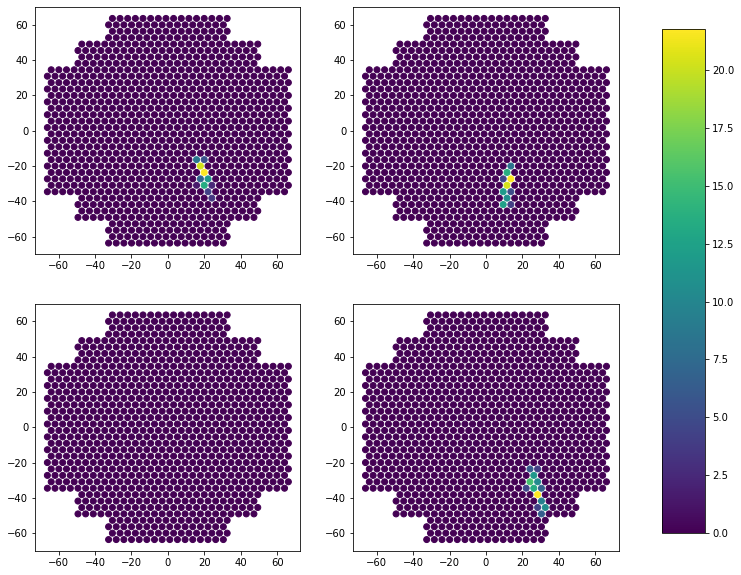

In [10]:
example_event = data_final[0]
fig, axs = plt.subplots(2,2,figsize=(12,10))
for i,ax in enumerate(axs.flatten()):
    ax_temp = ax.scatter(camera_coord['x'], camera_coord['y'], c=example_event[i])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax_temp, cax=cbar_ax)

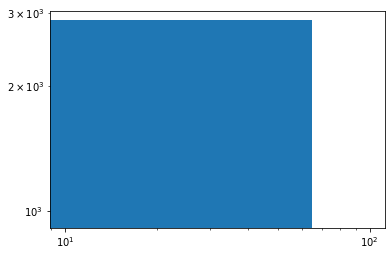

In [11]:
plt.hist(example_event.flatten());
plt.yscale('log')
plt.xscale('log')

In [12]:
ev, num_tel, num_pix = data_final.shape
print('total number of data points: ', ev*num_tel*num_pix)
print('data points with non-zero values: ', np.count_nonzero(data_final))
print('{0:.1f}%'.format(np.count_nonzero(data_final)*100/(ev*num_tel*num_pix)))

total number of data points:  13562880
data points with non-zero values:  2341636
17.3%


### let's make the graph for the pytorch-geometric

#### let's only consider each tel separately

In [14]:
allEvents = list()
xc = np.array(camera_coord['x'])
yc = np.array(camera_coord['y'])
for i in range(len(data_final)):
    for j in range(4):
        allEvents.append(np.stack((xc,yc,data_final[i][j]))) #x,y,pe      

In [15]:
import torch
from torch_geometric.data import Data

In [16]:
xc = camera_coord['x'].to_numpy()
yc = camera_coord['y'].to_numpy()
tel_loc = {'ct1': np.array([-0.16, -85.04, 0.97])*100, #x, y, z in cm
           'ct2': np.array([85.07, -0.37, 0.33])*100,
           'ct3': np.array([0.24, 85.04, -0.82])*100,
           'ct4': np.array([-85.04, 0.28, -0.48])*100}
cam_pixels_in_array = dict()
#calculate pixel coordinates from the center of the array - no z axis at the moment
for tel in tel_loc.keys():
    cam_pixels_in_array[tel] = np.array([tel_loc[tel][0] + xc, tel_loc[tel][1] + yc])
cam_pixels_in_array['ct1'].shape

(2, 960)

In [104]:
%%time
data_list = list()
for ev in range(len(data_final)):
    pe = list()
    x = list()
    y = list()
    for ct_num,ct in enumerate(cam_pixels_in_array.keys()):
        pe.append(data_final[ev][ct_num][data_final[ev][ct_num] > 0])
        x.append(cam_pixels_in_array[ct][0][data_final[ev][ct_num] > 0])
        y.append(cam_pixels_in_array[ct][1][data_final[ev][ct_num] > 0])
    pe = np.concatenate(pe, axis=0).flatten()
    x = np.concatenate(x, axis=0).flatten()
    y = np.concatenate(y, axis=0).flatten()
    max_pe = np.max(pe)
    max_pe_index = np.argmax(pe)
    #let's define the connections (edges) between the nodes here
    edges = []
    #Two pixels in any of the cameras have the differece from the highest measured signal of less than < pe_level
    #The idea is these signals are coming from the same part of the shower
    for sig in range(len(pe)):
        ratio_pe = pe[sig]/max_pe
        if (ratio_pe > 0.9 and ratio_pe < 1):
            edges.append([max_pe_index,sig])
    possible_edge_comb = list(it.combinations(np.unique(np.arange(len(pe))),2))
    for i, j in possible_edge_comb:
        dist = np.sqrt((x[j]-x[i])*(x[j]-x[i]) + (y[j]-y[i])*(y[j]-y[i]))
        #connection is defined if:
        #The two pixels which has seen light are < 10 cm from each other
        #10 cm is random for now..
        if (dist > 1.e-2 and dist < 10):
            edges.append([i,j])
    edge_index = torch.tensor(np.array(edges), dtype=torch.long)
    #print(edge_index.shape)
    nodes = torch.t(torch.tensor(np.array((x,y,pe)), dtype=torch.float))
    if(np.array(edges).max() > len(pe)):
        print('smothing is not right', np.array(edges).max(), len(pe))
        print(np.array(edges), pe)
        break
    if(ev%2 == 0):
        data = Data(x=nodes, edge_index=edge_index.t().contiguous(), y=0)
    else:
        data = Data(x=nodes, edge_index=edge_index.t().contiguous(), y=1)
    data_list.append(data)

CPU times: user 42.3 s, sys: 65.3 ms, total: 42.4 s
Wall time: 42.4 s


In [105]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

In [110]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

### make dataset using the numpy array created above

In [111]:
train_dataset = data_list[:int(0.6*len(data_list))]
test_dataset = data_list[int(0.6*len(data_list)):]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 2119
Number of test graphs: 1413


In [112]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print("number of node features:", data.num_node_features)
    if(step > 3):
        break

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[4329, 3], edge_index=[2, 20685], y=[64], batch=[4329], ptr=[65])
number of node features: 3
Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[4111, 3], edge_index=[2, 18191], y=[64], batch=[4111], ptr=[65])
number of node features: 3
Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[3142, 3], edge_index=[2, 12348], y=[64], batch=[3142], ptr=[65])
number of node features: 3
Step 4:
Number of graphs in the current batch: 64
DataBatch(x=[3928, 3], edge_index=[2, 17927], y=[64], batch=[3928], ptr=[65])
number of node features: 3
Step 5:
Number of graphs in the current batch: 64
DataBatch(x=[2896, 3], edge_index=[2, 11295], y=[64], batch=[2896], ptr=[65])
number of node features: 3


In [113]:
model = GCN(hidden_channels=64,num_node_features=3)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 10):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

GCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)
Epoch: 001, Train Acc: 0.4998, Test Acc: 0.5004
Epoch: 002, Train Acc: 0.5002, Test Acc: 0.4996
Epoch: 003, Train Acc: 0.4998, Test Acc: 0.5004
Epoch: 004, Train Acc: 0.5002, Test Acc: 0.4996
Epoch: 005, Train Acc: 0.4998, Test Acc: 0.5004
Epoch: 006, Train Acc: 0.5002, Test Acc: 0.4996
Epoch: 007, Train Acc: 0.4998, Test Acc: 0.5004
Epoch: 008, Train Acc: 0.4998, Test Acc: 0.5004
Epoch: 009, Train Acc: 0.4998, Test Acc: 0.5004


In [ ]:
numEnt = tree.GetEntries()
print "Number of Entries" ,numEnt
for entry in range(numEnt):
    tree.GetEntry(1)
    for i in range(obsPE.size()):
        print()
        ObsPE.append(obsPE[i])
        ExpPE.append(expPE[i])
        Likelihood.append(likelihood[i])
    ObsPE = np.array(ObsPE)
    ExpPE = np.array(ExpPE)
    Likelihood = np.array(Likelihood)

In [11]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[1],
                           [ 2]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

In [12]:
print(data.keys)

['x', 'edge_index']


In [13]:
data.is_directed()

True

In [ ]:
data_list = []
for i, ev in enumerate(allEvents):
    pe = ev[2]
    x = ev[0][pe > 0]
    y = ev[1][pe > 0]
    pe = pe[pe > 0]
    sum_pe = np.sum(pe)
    if(sum_pe > 0):
        x_com = np.sum(x*pe)/sum_pe
        y_com = np.sum(y*pe)/sum_pe
        edges = []
        for i in range(len(pe)):
            origX = x[i]
            origY = y[i]
            for j in range(len(pe)):
                tempX = x[j]
                tempY = y[j]
                dist = np.sqrt((tempX-origX)**2 + (tempY-origY)**2)
                if dist > 1.e-1 and dist < 10:
                    edges.append([i,j])
        edge_index = torch.tensor(np.array(edges), dtype=torch.long)
        pe = np.array(pe)
        x = np.array(x - x_com)
        y = np.array(y - y_com)
        nodes = torch.t(torch.tensor(np.array((x,y,pe)), dtype=torch.float))
        if(i%2 == 0):
            data = Data(x=nodes, edge_index=edge_index.t().contiguous(), y=0)
        else:
            data = Data(x=nodes, edge_index=edge_index.t().contiguous(), y=1)
        data_list.append(data)
    #print('num edges, points:',len(edges), len(pe))